# Getting Started

This notebook gets you started with a brief nDCG evaluation with LensKit for Python with a simple experiment with the MovieLens 100K data set.

## Setup

We first need to install LensKit:

In [5]:
help(lenskit.datasets)

NameError: name 'lenskit' is not defined

Now we can import LensKit utilities:

In [16]:
from lenskit.datasets import MovieLens
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn
from lenskit import topn

And Pandas is very useful:

In [7]:
import pandas as pd

## Loading Data

We're going to use the ML-100K data set:

In [21]:
ml_data = MovieLens('../data/01_raw/ml-latest-small')
ratings = ml_data.ratings
ratings.head()

,user,item,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Defining Algorithms

Let's set up two algorithms:

In [22]:
algo_ii = knn.ItemItem(20)
algo_als = als.BiasedMF(50)

## Running the Evaluation

In LensKit, our evaluation proceeds in 2 steps:

1. Generate recommendations
2. Measure them

If memory is a concern, we can measure while generating, but we will not do that for now.

We will first define a function to generate recommendations from one algorithm over a single partition of the data set.  It will take an algorithm, a train set, and a test set, and return the recommendations.

**Note:** before fitting the algorithm, we clone it.  Some algorithms misbehave when fit multiple times.

**Note 2:** our algorithms do not necessarily implement the `Recommender` interface, so we adapt them. This fills in a default candidate selector.

The code function looks like this:

In [23]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

Now, we will loop over the data and the algorithms, and generate recommendations:

In [30]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
#     all_recs.append(eval('ALS', algo_als, train, test))

In [47]:
# 
all_recs

[         item     score  user  rank Algorithm
 0      127152  6.421875     9     1  ItemItem
 1      142422  6.421875     9     2  ItemItem
 2      162478  6.171875     9     3  ItemItem
 3      161580  6.005208     9     4  ItemItem
 4      110669  5.921875     9     5  ItemItem
 ...       ...       ...   ...   ...       ...
 12195    2314  4.266134   609    96  ItemItem
 12196    3813  4.256936   609    97  ItemItem
 12197   30745  4.253068   609    98  ItemItem
 12198   50851  4.252631   609    99  ItemItem
 12199    5949  4.251036   609   100  ItemItem
 
 [12200 rows x 5 columns],
          item     score  user  rank Algorithm
 0       97866  5.604500     5     1  ItemItem
 1      142115  5.438471     5     2  ItemItem
 2      103107  5.285372     5     3  ItemItem
 3       83827  5.255212     5     4  ItemItem
 4        3855  5.238338     5     5  ItemItem
 ...       ...       ...   ...   ...       ...
 12195    1950  4.582399   606    96  ItemItem
 12196   71131  4.575087   606 

With the results in place, we can concatenate them into a single data frame:

In [25]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,Algorithm
0,97866,6.052074,5,1,ItemItem
1,142115,5.903903,5,2,ItemItem
2,103107,5.455359,5,3,ItemItem
3,106642,5.380351,5,4,ItemItem
4,3855,5.345925,5,5,ItemItem


To compute our analysis, we also need to concatenate the test data into a single frame:

In [26]:
test_data = pd.concat(test_data, ignore_index=True)

We analyze our recommendation lists with a `RecListAnalysis`.  It takes care of the hard work of making sure that the truth data (our test data) and the recoommendations line up properly.

We do assume here that each user only appears once per algorithm. Since our crossfold method partitions users, this is fine.

In [27]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.head()

nrecs  ndcg
Algorithm user             
ItemItem  1     100.0   0.0
          2     100.0   0.0
          3     100.0   0.0
          4     100.0   0.0
          5     100.0   0.0

Now we have nDCG values!

In [28]:
results.groupby('Algorithm').ndcg.mean()

Algorithm
ItemItem    0.003563
Name: ndcg, dtype: float64

Adn we can plot them:

<AxesSubplot:xlabel='Algorithm'>

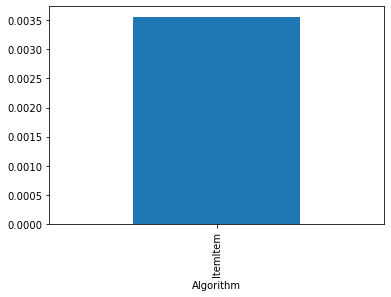

In [29]:
results.groupby('Algorithm').ndcg.mean().plot.bar()